In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

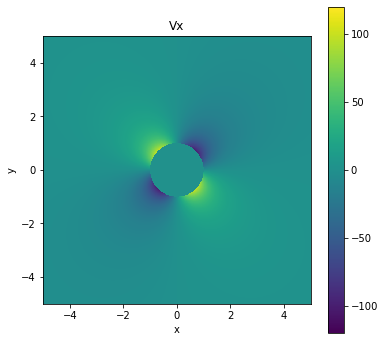

97.9839321942598


In [6]:
RE = 1.5E+6 # unit: m
x = np.linspace(-5*RE, 5*RE, 1000)
y = x
xmesh, ymesh = np.meshgrid(x, y)

alp = 0.01
V0 = 100*1E+3 # unit: m/s
RC = RE

r = np.sqrt(xmesh**2 + ymesh**2) # unit: m
Vx = -2*(1-alp)*V0*((RC/r)**2)*(xmesh*ymesh)/(r**2)
Vx[np.where(r<RE)] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect(1)
ax.set_title('Vx')
ax.set_xlabel('x')
ax.set_ylabel('y')
pcm = ax.pcolormesh(xmesh/RE, ymesh/RE, Vx/1000, vmin=-120, vmax=120)
fig.colorbar(pcm, ax=ax)
plt.show()
print(np.max(Vx)/1000)
